In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from slams.mcs import *
from slams.nn import *
from slams.score import *
from slams.utils import *

import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

### Generate data

In [3]:
# Data constants
size = 64
n_data = 8192
length = 64
dt = 0.2

In [4]:
# Generate data
generate_new = False

if generate_new:
    all_x = []
    kolmogorov = KolmogorovFlow(size=size, dt=dt)

    # Sample x
    for n in tqdm(range(n_data)):
        x = kolmogorov.prior()
        x = kolmogorov.trajectory(x, length=length)
        x = x[length//2:]
        all_x.append(x)

    x = torch.stack(all_x)
    torch.save(x, '../data/kolmogorov/x.pt')
    
else:
    x = torch.load('../data/kolmogorov/x.pt')


In [5]:
# Split data
i = int(0.8 * len(x))
j = int(0.9 * len(x))

train_x = x[:i]
val_x = x[i:j]
test_x = x[j:]

CUDA backend failed to initialize: Found cuDNN version 8500, but JAX was built against version 8600, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


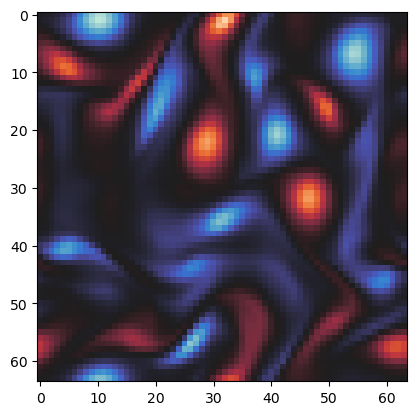

In [6]:
# Visualize testing data
sample_id = 0
timestep = 0

kolmogorov = KolmogorovFlow(size=size, dt=dt)
w = kolmogorov.vorticity(test_x[sample_id])

f, ax = plt.subplots()
ax.imshow(w[timestep], cmap=sns.cm.icefire)

### Train encoder-decoder: for state estimation...

In [7]:
# Dataset construction
input_size = 2
latent_channels = [1]
kernel_sizes = [63]
window = 1
batch_size = 64

trainset = TrajectoryDataset(train_x, window=window, flatten=True)
validset = TrajectoryDataset(val_x , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [9]:
train_new = True

if train_new:
    
    # Define hyperparameters
    epochs = 256
    learning_rate = 2e-4
    weight_decay = 1e-3

    # Initialize model and optimizer
    latent = ConvEncoderDecoder(window * input_size, latent_channels, kernel_sizes).to(device)
    optimizer = torch.optim.AdamW(latent.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    all_train_losses = []
    all_valid_losses = []

    for epoch in tqdm(range(epochs)):
        losses_train = []
        losses_valid = []

        latent.train()

        for batch in trainloader:
            x, kwargs = batch
            x = x.to(device)

            z = latent.encoder(x)
            x_ = latent.decoder(z)
            l = (kolmogorov.vorticity(x_) - kolmogorov.vorticity(x)).square().mean()
            l.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses_train.append(l.detach())

        ## Valid
        latent.eval()

        with torch.no_grad():
            for batch in validloader:
                x, kwargs = batch
                x = x.to(device)

                z = latent.encoder(x)
                x_ = latent.decoder(z)
                l = (kolmogorov.vorticity(x_) - kolmogorov.vorticity(x)).square().mean()

                losses_valid.append(l.detach())

        ## Stats
        all_train_losses.append(torch.stack(losses_train).mean().item())
        all_valid_losses.append(torch.stack(losses_valid).mean().item())
        
    # Plot losses
    f, ax = plt.subplots()
    ax.plot(np.array(all_train_losses), label='train')
    ax.plot(np.array(all_valid_losses), label='valid')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error')
    ax.legend()

    torch.save(latent, '../logs/kolmogorov/latent.pt')
    
else:
    
    latent = torch.load('../logs/kolmogorov/latent.pt')

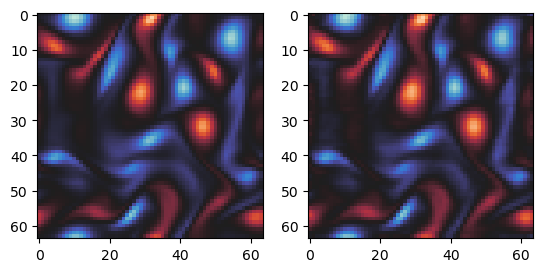

In [10]:
# Qualitative sanity check
test_idx, time_idx = 0, 0

# True
kolmogorov = KolmogorovFlow(size=size, dt=dt)
w_true = kolmogorov.vorticity(test_x[test_idx])

# Preds
z = latent.encoder(test_x[test_idx].to(device))
x_ = latent.decoder(z)
w_pred = kolmogorov.vorticity(x_.detach().cpu())

# Plot
f, ax = plt.subplots(1,2)
ax[0].imshow(w_true[time_idx], cmap=sns.cm.icefire) # True
ax[1].imshow(w_pred[time_idx], cmap=sns.cm.icefire) # Predicted

### Train diffusion model

In [11]:
# Latent dataset creation
input_size = 2
batch_size = 64
window = 5
order = window // 2
embedding = 64
hidden_channels = (32, 64, 128)
hidden_blocks = (3, 3, 3)
kernel_size = 3

trainset = TrajectoryDataset(train_x, window=window, flatten=True)
validset = TrajectoryDataset(val_x , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [12]:
# Network
score = MCScoreNet(input_size, order=window // 2)
score.kernel = LocalScoreUNet(
        channels=window * input_size,
        size=size,
        embedding=embedding,
        hidden_channels=hidden_channels,
        hidden_blocks=hidden_blocks,
        kernel_size=kernel_size,
        activation=torch.nn.SiLU,
        spatial=2,
        padding_mode='circular',
    )

sde = VPSDE(score.kernel, shape=(window * input_size, size, size)).to(device)


In [13]:
# diffusion
x, kwargs = next(iter(trainloader))
x = x.to(device)
sde.loss(x, **kwargs)

tensor(1.1418, device='cuda:0', grad_fn=<MeanBackward0>)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [1:50:22<00:00, 51.74s/it]


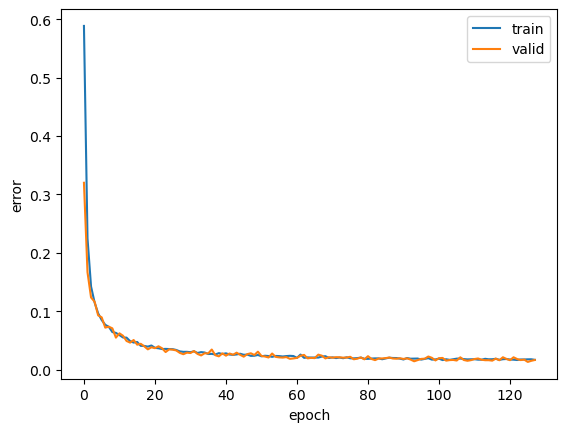

In [14]:
train_new = True

if train_new:
    
    # Defining hyperparemeters
    epochs = 128
    learning_rate = 2e-4
    weight_decay = 1e-3
    lr = lambda t: 1 - (t / epochs)

    optimizer = torch.optim.AdamW(sde.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

    # Training loop
    all_train_losses = []
    all_valid_losses = []

    for epoch in tqdm(range(epochs)):
        losses_train = []
        losses_valid = []

        sde.train()
        for batch in trainloader:
            x, kwargs = batch
            x = x.to(device)

            # compute noise differential loss
            l = sde.loss(x, **kwargs)
            l.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses_train.append(l.detach())

        ## Valid
        sde.eval()

        with torch.no_grad():
            for batch in validloader:
                x, kwargs = batch
                x = x.to(device)
                l = sde.loss(x, **kwargs)
                losses_valid.append(l.detach())

        ## Stats
        all_train_losses.append(torch.stack(losses_train).mean().item())
        all_valid_losses.append(torch.stack(losses_valid).mean().item())

        ## Step
        scheduler.step()
        
    # Plot losses
    f, ax = plt.subplots()
    ax.plot(np.array(all_train_losses), label='train')
    ax.plot(np.array(all_valid_losses), label='valid')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error')
    ax.legend()
    
    torch.save(score, '../logs/kolmogorov/score_pixel.pt')

else:
    score = torch.load('../logs/kolmogorov/score_pixel.pt')

### Train latent diffusion model

In [15]:
# Latent dataset creation
hidden_size = latent_channels[-1]
l_size = size // (1 ** int(len(latent_channels)))
batch_size = 64
window = 5
order = window // 2
embedding = 64
hidden_channels = (32, 64, 128)
hidden_blocks = (3, 3, 3)
kernel_size = 3

train_z = get_latent(latent, train_x)
val_z = get_latent(latent, val_x)
test_z = get_latent(latent, test_x)

trainset = TrajectoryDataset(train_z, window=window, flatten=True)
validset = TrajectoryDataset(val_z , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [16]:
# Network
score_latent = MCScoreNet(input_size, order=window // 2)
score_latent.kernel = LocalScoreUNet(
        channels=window * hidden_size,
        embedding=embedding,
        hidden_channels=hidden_channels,
        hidden_blocks=hidden_blocks,
        kernel_size=kernel_size,
        activation=torch.nn.SiLU,
        spatial=2,
        padding_mode='circular',
    )

lsde = VPSDE(score_latent.kernel, shape=(window * input_size, l_size, l_size)).to(device)


In [17]:
# latent diffusion
x, kwargs = next(iter(trainloader))
x = x.to(device)
lsde.loss(x, **kwargs)

tensor(1.1407, device='cuda:0', grad_fn=<MeanBackward0>)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [1:46:58<00:00, 50.14s/it]


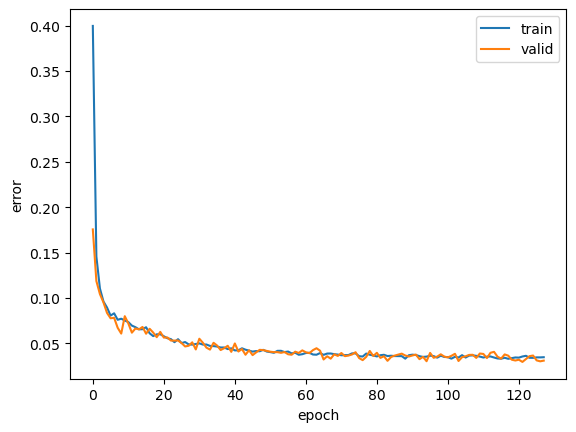

In [18]:
train_new = True

if train_new:
    
    # Defining hyperparameters
    epochs = 128
    learning_rate = 2e-4
    weight_decay = 1e-3
    lr = lambda t: 1 - (t / epochs)

    optimizer = torch.optim.AdamW(lsde.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

    # Training loop
    all_train_losses = []
    all_valid_losses = []

    for epoch in tqdm(range(epochs)):
        losses_train = []
        losses_valid = []

        lsde.train()
        for batch in trainloader:
            x, kwargs = batch
            x = x.to(device)

            # compute noise differential loss
            l = lsde.loss(x, **kwargs)
            l.backward()

            optimizer.step()
            optimizer.zero_grad()

            losses_train.append(l.detach())

        ## Valid
        lsde.eval()

        with torch.no_grad():
            for batch in validloader:
                x, kwargs = batch
                x = x.to(device)

                l = lsde.loss(x, **kwargs)

                losses_valid.append(l.detach())

        ## Stats
        all_train_losses.append(torch.stack(losses_train).mean().item())
        all_valid_losses.append(torch.stack(losses_valid).mean().item())

        ## Step
        scheduler.step()
        
    # Plot losses
    f, ax = plt.subplots()
    ax.plot(np.array(all_train_losses), label='train')
    ax.plot(np.array(all_valid_losses), label='valid')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error')
    ax.legend()
    
    torch.save(score_latent, '../logs/kolmogorov/score_latent.pt')
    
else:
    
    score_latent = torch.load('../logs/kolmogorov/score_latent.pt')
    

### Evaluation

Generate low frequency observations for assimilation (in latent space)

In [21]:
sigma_sq = 0.05

def A(x):
    return kolmogorov.coarsen(x[..., ::4, :, :, :], 8)

def get_conditionals(sample_id):
    """Sample from the testing set for evaluation purposes"""
    kolmogorov = KolmogorovFlow(size=size, dt=dt)
    
    # Truth
    true_x, true_z = test_x[sample_id, :29], test_z[sample_id, :29]
    
    # Obs
    y_obs = torch.normal(A(true_x), sigma_sq)
    yz_obs = torch.normal(A(true_z), sigma_sq)
    
    # For plotting
    w_true = kolmogorov.vorticity(true_x[::4])
    w_coarse = kolmogorov.vorticity(y_obs) / 2.5
    w_coarse = kolmogorov.upsample(w_coarse, 2, mode='nearest')
    
    return true_x, true_z, w_true, w_coarse, y_obs, yz_obs

In [22]:
n_states = 64
n_corrections = 1
n_steps = 512
sample_size = 1
tau = 0.5
all_x_sample = []

# Sampling for diffusion model
print('Processing pixel-space diffusion for state estimation...')
true_x, true_z, w_true, w_coarse, y_obs, yz_obs =  get_conditionals(sample_id=0)
sde_eval = VPSDE(
    GaussianScore(
        y_obs,
        A=A,
        std=sigma_sq,
        sde=VPSDE(score, shape=()),
    ),
    shape=true_x.shape).to(device)

x = sde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
x = kolmogorov.vorticity(x[::4])
all_x_sample.append(x)

# Sampling from latent diffusion model
print('Processing latent-space diffusion for state estimation...')
true_x, true_z, w_true, w_coarse, y_obs, yz_obs =  get_conditionals(sample_id=0)

lsde_eval = VPSDE(
    GaussianScore(
        y=yz_obs,
        A=A,
        std=sigma_sq,
        sde=VPSDE(score_latent, shape=()),
    ),
    shape=true_z.shape).to(device)

z = lsde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
x = latent.decoder(z)
x = kolmogorov.vorticity(x[::4])
all_x_sample.append(x)

# Combine all samples
all_x_sample = torch.stack(all_x_sample)

Processing pixel-space diffusion for state estimation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [07:02<00:00,  1.21it/s]


Processing latent-space diffusion for state estimation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [06:48<00:00,  1.25it/s]


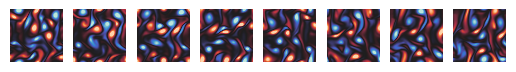

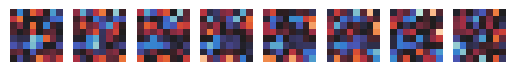

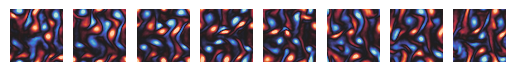

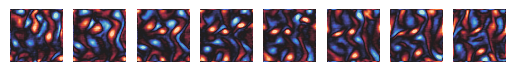

In [23]:
## 8x coarsening
# Plot true (first row)
f, ax = plt.subplots(1, len(w_true))
for N in range(w_true.shape[0]):
    ax[N].imshow(w_true[N], cmap=sns.cm.icefire, vmin=-1, vmax=1)
    ax[N].axis('off')
    
    
# Plot coarsen (second row)
f, ax = plt.subplots(1, len(w_coarse))
for N in range(w_coarse.shape[0]):
    ax[N].imshow(w_coarse[N], cmap=sns.cm.icefire, vmin=-1, vmax=1)
    ax[N].axis('off')
    
# Plot assimilation (third row: pixel-based; fourth row: latent-based)
for M in range(all_x_sample.shape[0]):
    x_sample = all_x_sample[M]
    x_sample = x_sample.detach().cpu()
    
    f, ax = plt.subplots(1, x_sample.shape[0])
    for N in range(x_sample.shape[0]):
        ax[N].imshow(x_sample[N], cmap=sns.cm.icefire, vmin=-1, vmax=1)
        ax[N].axis('off')